In [1]:
import time
from pprint import pprint
from IPython.display import display
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split

import torch
torch.set_default_dtype(torch.float64)

import e3nn
import e3nn.point.data_helpers as dh 
from training_utils import *

In [2]:
# make sure CUDA is available
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.version.cuda)
#print(torch.cuda.memory_summary())
device = "cuda"
#torch.rand(10).to(device)
#torch.rand(10, device=device)

0
1
Tesla V100-PCIE-32GB
True
10.1


In [3]:
relevant_elements = { "H", "C" }                            # only train on the shieldings at these elements
elementwide_scaling_factors = {"C":5.0, "H":1.5, "O":50.0}  # divide absolute shieldings by these numbers
n_elements = len(elementwide_scaling_factors)
all_elements = list(elementwide_scaling_factors.keys())

In [4]:
# represents the training data for one molecule
# all of these items are stored on the cpu
class Molecule():
    def __init__(self, name,               # name of molecule
                 atomic_symbols,           # vector of strings of length n_atoms
                 symmetrical_atoms,        # list of lists of 0-indexed atom numbers
                 stationary_shieldings,    # vector of floats of length n_atoms
                 geometries,               # (n_examples, n_atoms, 3)
                 perturbed_shieldings):    # (n_examples, n_atoms, 1) 
        self.name = name                                       
        self.stationary_shieldings = stationary_shieldings
        self.geometries = geometries                                               
        self.atomic_symbols = atomic_symbols
        self.n_atoms = len(atomic_symbols)
  
        # rescale shieldings for training
        perturbed_shieldings = perturbed_shieldings - stationary_shieldings
        scaling_factors = [ elementwide_scaling_factors[symbol] for symbol in atomic_symbols ]
        scaling_factors = np.array(scaling_factors)
        self.scaling_factors = scaling_factors
        perturbed_shieldings = perturbed_shieldings / scaling_factors
        self.perturbed_shieldings = perturbed_shieldings
        
        # compute features
        # one-hots for one example (since they're all the same): n_atoms, n_elements
        features = []
        for symbol,shielding in zip(atomic_symbols,stationary_shieldings):
            inner_list = [ 1. if symbol == i else 0. for i in all_elements ]
            #inner_list.append(shielding)
            features.append(inner_list)
        self.features = np.array(features)
    
        # compute per-atom weights for the loss function
        weights = [ 1.0 if symbol in relevant_elements else 0.0 for symbol in atomic_symbols ]
        weights = np.array(weights)
        for l in symmetrical_atoms:
            weight = 1.0/len(l)
            for i in l:
                weights[i] = weight
        self.weights = weights

In [5]:
molecules_dict = {}  # name -> Molecule

# read the training data
# iterate through the hdf5s (one per molecule)
for hdf5_filename in sorted(glob("*.hdf5")):
    with h5py.File(hdf5_filename, "r") as h5:
        name = h5.attrs.get("name")
        print(name)
        geometries_and_shieldings = np.array(h5.get("data"))
        geometries = geometries_and_shieldings[:,:,:3]
        perturbed_shieldings = geometries_and_shieldings[:,:,3]
        stationary_shieldings = np.array(h5.attrs.get("stationary"))
        atomic_symbols = list(h5.get("atomic_symbols"))
        atomic_symbols = [ symbol.decode("utf-8") for symbol in atomic_symbols ]
        n_atoms = len(atomic_symbols)

        # these are the 1-indexed atom numbers that are symmetrical
        group = h5.get("symmetrical_atoms")
        symmetrical_atoms = []  # 0-indexed
        for v in group.values():
            v = [ i-1 for i in v ]
            symmetrical_atoms.append(v)

        # store the results
        molecule = Molecule(name, atomic_symbols, symmetrical_atoms,
                            stationary_shieldings, geometries, perturbed_shieldings)
        molecules_dict[name] = molecule
        
molecules = np.array(list(molecules_dict.values()))

acetaldehyde
acetone
butanone
dimethyl_ether
ethane


In [6]:
# features are one-hots for every atom,
# so this is (number of one_hots, rank zero tensor, even parity)
Rs_in = [(n_elements,0,1)]

# we are outputing one scalar for every atom
# so this is (one, rank zero tensor, even parity)
Rs_out = [(1,0,1)]

# maximum extent of radial basis functions in Angstroms
max_radius = 4.0

In [7]:
# preprocess the neighbor information for the train and test sets
def create_torch_datasets(molecules, train_size, test_size, random_state):
    training_dataset = []
    testing_dataset = []
    for molecule in molecules:
        print(f"Preprocessing {molecule.name} data:")
        train_geometries, test_geometries, train_shieldings, test_shieldings = train_test_split(
                                                              molecule.geometries,
                                                              molecule.perturbed_shieldings,
                                                              train_size=train_size, test_size=test_size,
                                                              random_state=random_state)
        train_test = [(train_geometries,train_shieldings,training_dataset),
                      (test_geometries,test_shieldings,testing_dataset)]
        features = torch.tensor(molecule.features, dtype=torch.float64)
        weights = torch.tensor(molecule.weights, dtype=torch.float64) 
        i = 0
        n_to_save = len(train_geometries) + len(test_geometries)
        for geometries, shieldings, target in train_test:
            for g,s in zip(geometries,shieldings):
                g = torch.tensor(g, dtype=torch.float64)
                s = torch.tensor(s, dtype=torch.float64).unsqueeze(-1)  # [1,N]
                data = dh.DataNeighbors(x=features, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                        self_interaction=True, name=molecule.name,
                                        weights=weights, y=s, Rs_out = Rs_out)
                target.append(data)
                i += 1
                if (i+1) % 100 == 0:
                    print(f"{i+1:10d} of {n_to_save:10d}...", end="\r", flush=True)
                if i == n_to_save - 1:
                    print(f"{i+1:10d} of {n_to_save:10d}               done!")
    return training_dataset, testing_dataset

In [25]:
training_dataset, test_dataset = create_torch_datasets(molecules,
                                                       train_size =95000,
                                                       test_size = 5000,
                                                       random_state = 8)
# training_dataset, test_dataset = create_torch_datasets(training_molecules,
#                                                        train_size = 20000,
#                                                        test_size = 5000,
#                                                        random_state = 1)
# _, final_testing_dataset = create_torch_datasets(testing_molecules,
#                                                  train_size = 1,
#                                                  test_size = 5000,
#                                                  random_state = 1)

Preprocessing acetaldehyde data:
    100000 of     100000               done!
Preprocessing acetone data:
    100000 of     100000               done!
Preprocessing butanone data:
    100000 of     100000               done!
Preprocessing dimethyl_ether data:
    100000 of     100000               done!
Preprocessing ethane data:
    100000 of     100000               done!


In [9]:
# mean-squared loss
def loss_function(output, data):
    predictions = output
    observations = data.y
    weights = data.weights
    normalization = weights.sum()
    residuals = (predictions-observations)
    loss = residuals.square() * weights
    loss = loss.sum() / normalization
    loss = loss.pow(0.5)
    return loss, residuals

In [21]:
# define the neural network architecture
model_kwargs = {
    'network': 'GatedConvParityNetwork', 
    'conv': 'Convolution',
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'mul': 7,                 # how many copies of each tensor at each layer
    'lmax': 3,                 # maximum angular momentum
    'layers': 3,               # number of layers
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 30,     # number of Gaussians in radial kernel?
}
model = model_from_kwargs(model_kwargs)
model.to(device);

In [11]:
# load first two layers from pre-trained model
model_dict = torch.load("small-model1.torch")
state_dict = model_dict["state_dict"]
parameters_to_transfer = {}
for name, value in state_dict.items():
    fields = name.split(".")
    layer = int(fields[1])
    if layer <= 2:
        parameters_to_transfer[name] = value
missing_keys, unexpected_keys = model.load_state_dict(parameters_to_transfer, strict=False)
#print("missing keys")
#print(missing_keys)
#print()
#print("unexpected keys")
#print(unexpected_keys)

In [12]:
# freeze first two layers
for name, param in model.named_parameters():
    fields = name.split(".")
    layer = int(fields[1])
    if layer <= 2:
        param.requires_grad = False
    #print(name,param.requires_grad)

In [ ]:
# unfreeze all layers
for param in model.parameters():
    param.requires_grade = True

In [26]:
# training parameters
learning_rate = 1e-3
parameters = filter(lambda p: p.requires_grad, model.parameters())
opt = torch.optim.Adam(model.parameters(), learning_rate)
epochs = 100       
n_norm = 7           # n_norm is average number of convolution neighbors per atom
batch_size = 50

In [27]:
# prepare to train model
torch.cuda.empty_cache()

training_size = len(training_dataset)
n_training_batches = int(training_size / batch_size)
training_dataloader = tg.data.DataListLoader(training_dataset, batch_size=batch_size, shuffle=True)

testing_size = len(test_dataset)
n_testing_batches = int(testing_size / batch_size)
testing_dataloader = tg.data.DataListLoader(test_dataset, batch_size=batch_size, shuffle=False)

results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
history = []      # index is epoch, items are (train_loss, test_loss)

In [ ]:
# train model
start_time = time.time()
for i in range(epochs):
    start_time = time.time()
    
    # training
    training_loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(training_dataloader):
        # forward pass
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        loss, residuals = loss_function(output, data)
        
        # backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # update training loss
        temp_loss = loss.detach()
        training_loss_cum += loss.detach().pow(2)
        current_cum = np.sqrt(training_loss_cum.item() / (j+1))
        print(f"Iteration {i+1:<4d}    train {j+1:5d} / {n_training_batches:5d}  loss = {temp_loss.item():12.3f}    cum_loss = {current_cum:12.3f}            ", end="\r", flush=True)
        
    training_loss_cum = np.sqrt((training_loss_cum.item()/(j+1)))
    
    # testing
    testing_loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(testing_dataloader):
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        
        with torch.no_grad():
            # run model
            output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)

            # compute MSE
            loss, residuals = loss_function(output,data)
            testing_loss_cum += loss.pow(2)
        print(f"Iteration {i+1:<4d}    test {j+1:5d} / {n_testing_batches:5d}  loss = {loss.item():12.3f}                                  ", end="\r", flush=True)
    
    testing_loss_cum = np.sqrt((testing_loss_cum.item()/(j+1)))
    end_time = time.time()
    elasped_time = end_time - start_time
    history.append((training_loss_cum, testing_loss_cum))
    print(f"Iteration {i+1:<4d}        training = {training_loss_cum.item():<12.3f}    testing = {testing_loss_cum.item():<12.3f}     elapsed = {elasped_time:7.2f} s                     ", end="\r", flush=True)
    print()
    #if i == 0 or (i+1) % 10 == 0:
    #    print()

Iteration 1           training = 1.056           testing = 0.798            elapsed = 6302.76 s                     


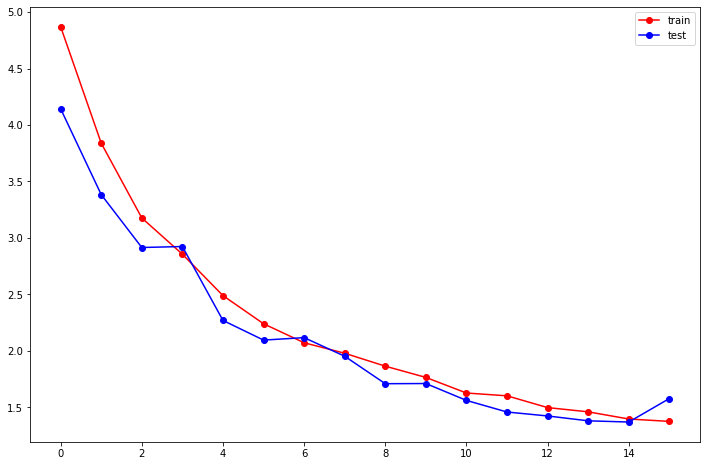

In [408]:
# plot learning curve
plt.figure(figsize=(12,8))
epoch = list(range(len(history)))
epoch = np.array(epoch)
epoch2 = epoch + 0.5
training_loss = [ training for training,testing in history ]
testing_loss = [ testing for training,testing in history ]
plt.plot(epoch, training_loss, "ro-", label="train")
plt.plot(epoch2, testing_loss, "bo-", label="test")
plt.legend(loc="best")
plt.show()

In [409]:
# test the model as it now
torch.cuda.empty_cache()
testing_dataloader = tg.data.DataListLoader(test_dataset, batch_size=batch_size, shuffle=False)
testing_size = len(test_dataset)
n_batches = int(testing_size / batch_size)
results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
start_time = time.time()

loss_cum = torch.tensor([0.]).to(device)
for j,data in enumerate(testing_dataloader):
    print(f"batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
    data = tg.data.Batch.from_data_list(data)
    data.to(device)
    with torch.no_grad():
        # run model
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        
        # compute MSE
        loss, residuals = loss_function(output,data)
        loss_cum += loss.pow(2)
        
        # rescale residuals back to ppm and store
        residuals = residuals.squeeze(-1).cpu().numpy()
        i=0
        for name in data.name:
            molecule = molecules_dict[name]
            n_atoms = molecule.n_atoms
            scaling_factors = molecule.scaling_factors
            if name not in results_dict:
                results_dict[name] = []
            subset = residuals[i:i+n_atoms] * scaling_factors
            results_dict[name].append(subset)
            i += n_atoms
            
loss_cum = loss_cum/(j+1)
loss_cum = loss_cum.pow(0.5)
end_time = time.time()
elasped_time = end_time - start_time
print(f"\nOverall loss is {loss_cum.item():.6f}.  Evaluation took {elasped_time:.2f} s.")

batch    50 /    50
Overall loss is 1.296091.  Evaluation took 7.82 s.


In [410]:
# reshape residual data
results_dict2 = {}
for name,results in results_dict.items():
    results = np.array(results).T
    molecule = molecules_dict[name]
    atomic_symbols = molecule.atomic_symbols
    for i,v in enumerate(results):
        element = atomic_symbols[i]
        if element not in relevant_elements:
            continue
        label = f"{name}_{element}{i+1}"
        results_dict2[label]=v

In [411]:
# summary stats
df = pd.DataFrame(results_dict2)
means = df.mean()
ranges = df.max()-df.min()
RMSEs = np.sqrt(df.pow(2).mean())
df = pd.concat([means,ranges,RMSEs], axis=1)
df.columns = ["mean","range","RMSE"]
df = df.round(2)
display(df)

,mean,range,RMSE
acetaldehyde_C1,0.07,2.66,0.27
acetaldehyde_C3,0.21,3.12,0.32
acetaldehyde_H4,0.00,0.38,0.04
acetaldehyde_H5,-0.00,0.44,0.05
acetaldehyde_H6,-0.01,0.51,0.05
acetaldehyde_H7,-0.02,0.81,0.06
acetone_C1,0.09,2.25,0.24
acetone_C3,0.11,1.74,0.25
acetone_H4,0.00,0.41,0.04
acetone_H5,-0.00,0.32,0.04


In [412]:
def save_model(model_kwargs, model, filename, optimizer=None):
    model_dict = {
        'state_dict': model.state_dict(),
        'model_kwargs': model_kwargs
    }
    if optimizer is not None:
        model_dict['optimizer_state_dict'] = optimizer.state_dict()
    torch.save(model_dict, filename)

In [413]:
save_model(model_kwargs, model, "small-model2.torch", optimizer=opt)